# Exploratory Data Analysis (EDA)

## Table of Contents
1. Preparing the Datasets
2. Visualizing the Datasets
3. Feature Engineering on Train Dataset Part 1 
4. Handle Missing Values
5. Feature Engineering on Train Dataset Part 2 
6. Bar Charts with Confidence Intervals for Two Self-created Variables
7. Feature Engineering on Train Dataset Part 3 
8. Feature Engineering on Test Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

## Preparing the Datasets

In [20]:
train_df = pd.read_csv('../Data/train.csv')
test_df = pd.read_csv('../Data/test.csv')
weather_df = pd.read_csv('../Data/wetter.csv')
kiwo_df = pd.read_csv('../Data/kiwo.csv')

sample_df = pd.read_csv('../Data/sample_submission.csv')

In [21]:
train_df = train_df.sort_values('Datum')
test_df = test_df.sort_values('Datum')

In [22]:
train_df

,id,Datum,Warengruppe,Umsatz
0,1307011,2013-07-01,1,148.828353
3638,1307013,2013-07-01,3,201.198426
7223,1307015,2013-07-01,5,317.475875
1819,1307012,2013-07-01,2,535.856285
5457,1307014,2013-07-01,4,65.890169
...,...,...,...,...
9041,1807315,2018-07-31,5,261.341313
1818,1807311,2018-07-31,1,123.075682
5456,1807313,2018-07-31,3,285.872616
3637,1807312,2018-07-31,2,586.081666


In [23]:
test_df

,id,Datum,Warengruppe
0,1808011,2018-08-01,1
710,1808013,2018-08-01,3
1065,1808014,2018-08-01,4
1419,1808015,2018-08-01,5
355,1808012,2018-08-01,2
...,...,...,...
354,1907301,2019-07-30,1
709,1907302,2019-07-30,2
1773,1907305,2019-07-30,5
1418,1907304,2019-07-30,4


In [24]:
train_df['Datum'] = pd.to_datetime(train_df['Datum'], format='mixed', dayfirst=True, errors='coerce')
test_df['Datum'] = pd.to_datetime(test_df['Datum'], format='mixed', dayfirst=True, errors='coerce')

In [25]:
train_df.isna().any()

id             False
Datum          False
Warengruppe    False
Umsatz         False
dtype: bool

In [26]:
test_df.isna().any()

id             False
Datum          False
Warengruppe    False
dtype: bool

## Visualizing the Datasets

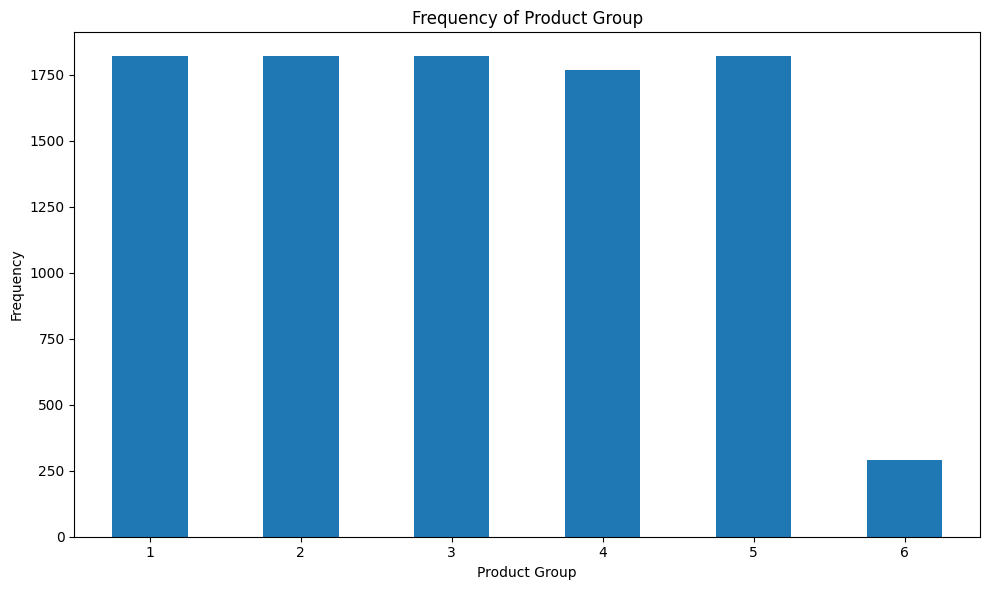

In [27]:
waren_gruppe_counts = train_df["Warengruppe"].value_counts().sort_index()
plt.figure(figsize=(10, 6))
waren_gruppe_counts.plot(kind='bar')

plt.title('Frequency of Product Group')
plt.xlabel('Product Group')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

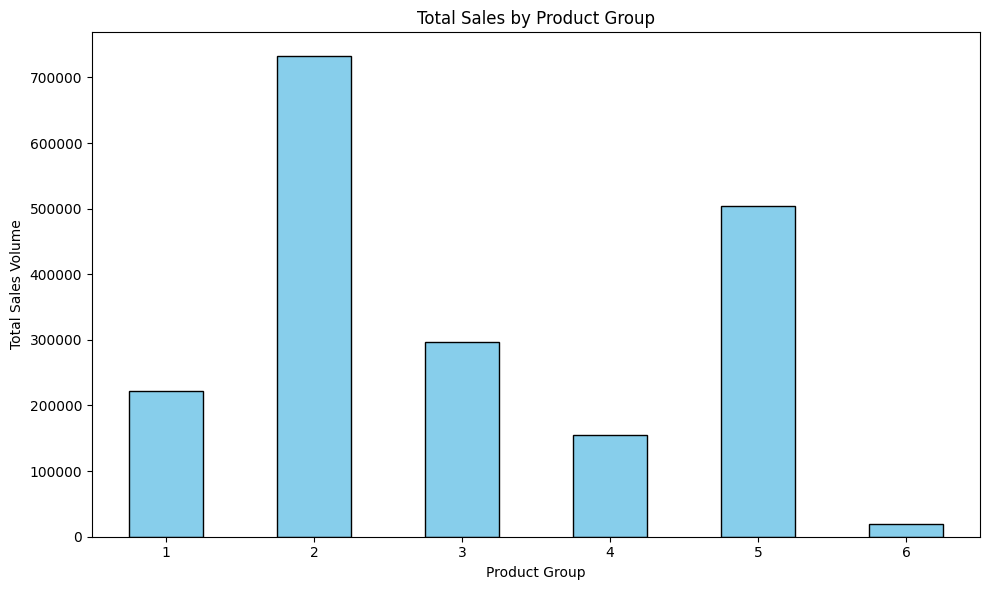

In [28]:
category_sales = train_df.groupby('Warengruppe')['Umsatz'].sum()
plt.figure(figsize=(10, 6))
category_sales.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Total Sales by Product Group')
plt.xlabel('Product Group')
plt.ylabel('Total Sales Volume')
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

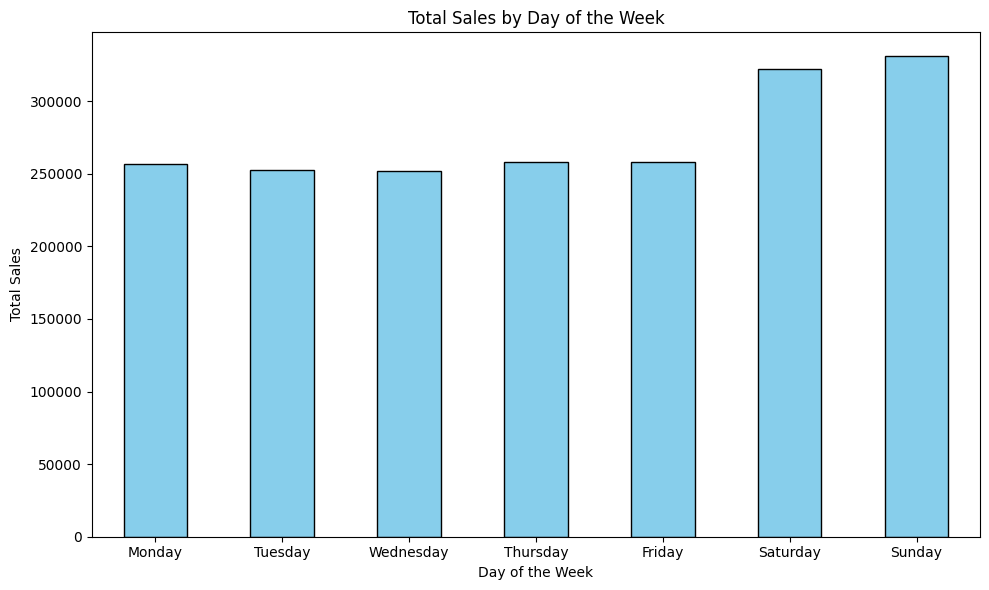

In [29]:
train_df['Datum'] = pd.to_datetime(train_df['Datum'])  
train_df['weekday'] = train_df['Datum'].dt.day_name()

weekday_sales = train_df.groupby('weekday')['Umsatz'].sum()
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales = weekday_sales.reindex(ordered_days)

plt.figure(figsize=(10, 6))
weekday_sales.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Total Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [30]:
kiwo_df['Datum'] = pd.to_datetime(kiwo_df['Datum'])

In [31]:
merged_df = pd.merge(train_df, kiwo_df, on='Datum', how='left')

In [32]:
merged_df.isna().any()

id             False
Datum          False
Warengruppe    False
Umsatz         False
weekday        False
KielerWoche     True
dtype: bool

In [33]:
merged_df['KielerWoche'] = merged_df['KielerWoche'].fillna(0)

In [34]:
merged_df.isna().any()

id             False
Datum          False
Warengruppe    False
Umsatz         False
weekday        False
KielerWoche    False
dtype: bool

In [35]:
merged_df

,id,Datum,Warengruppe,Umsatz,weekday,KielerWoche
0,1307011,2013-07-01,1,148.828353,Monday,0.0
1,1307013,2013-07-01,3,201.198426,Monday,0.0
2,1307015,2013-07-01,5,317.475875,Monday,0.0
3,1307012,2013-07-01,2,535.856285,Monday,0.0
4,1307014,2013-07-01,4,65.890169,Monday,0.0
...,...,...,...,...,...,...
9329,1807315,2018-07-31,5,261.341313,Tuesday,0.0
9330,1807311,2018-07-31,1,123.075682,Tuesday,0.0
9331,1807313,2018-07-31,3,285.872616,Tuesday,0.0
9332,1807312,2018-07-31,2,586.081666,Tuesday,0.0


In [36]:
merged_df["KielerWoche"].value_counts()

KielerWoche
0.0    9111
1.0     223
Name: count, dtype: int64

In [37]:
merged_df = merged_df.sort_values('Datum').reset_index(drop=True)

merged_df['kw_block'] = (merged_df['KielerWoche'] != merged_df['KielerWoche'].shift(1)).cumsum()

kw_blocks = merged_df[merged_df['KielerWoche'] == 1].groupby('kw_block').agg(
    start_date=('Datum', 'min'),
    end_date=('Datum', 'max')
).reset_index(drop=True)

print(kw_blocks)

  start_date   end_date
0 2014-06-21 2014-06-29
1 2015-06-20 2015-06-28
2 2016-06-18 2016-06-26
3 2017-06-17 2017-06-25
4 2018-06-16 2018-06-24


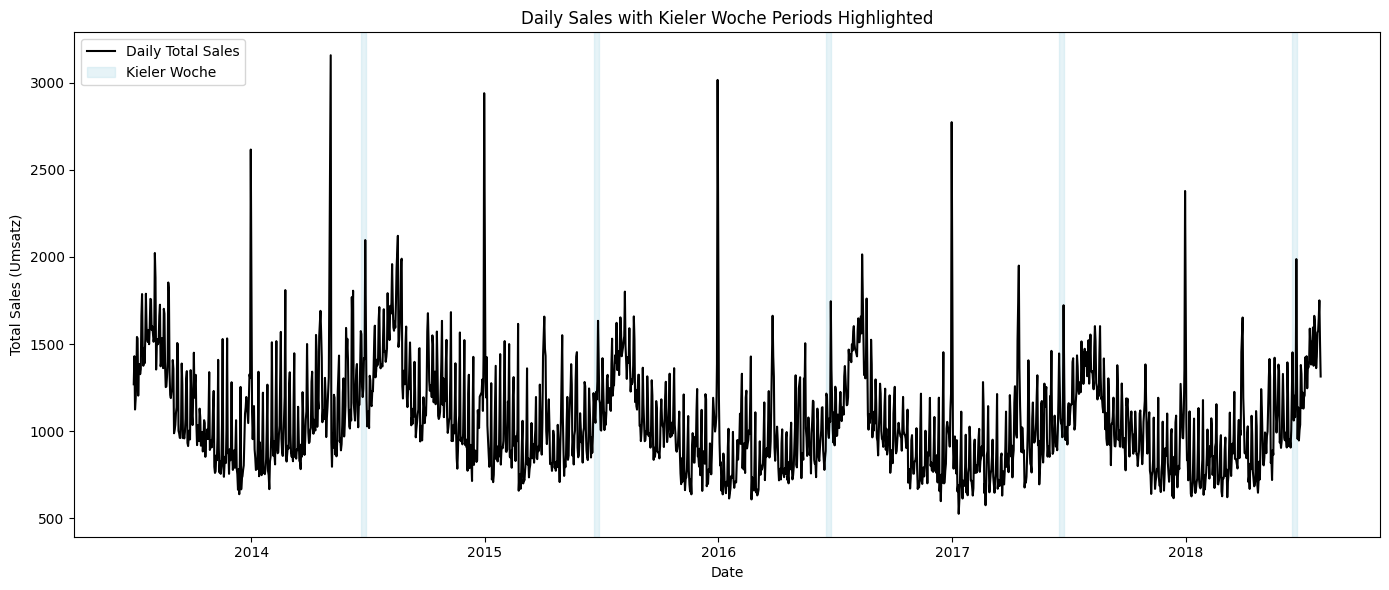

In [38]:
daily_sales = merged_df.groupby('Datum')['Umsatz'].sum().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(daily_sales['Datum'], daily_sales['Umsatz'], label='Daily Total Sales', color='black')

for _, row in kw_blocks.iterrows():
    plt.axvspan(row['start_date'], row['end_date'], color='lightblue', alpha=0.3, label='Kieler Woche')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel('Date')
plt.ylabel('Total Sales (Umsatz)')
plt.title('Daily Sales with Kieler Woche Periods Highlighted')
plt.tight_layout()
plt.show()

## Feature Engineering on Train Dataset Part 1

In [39]:
train_df

,id,Datum,Warengruppe,Umsatz,weekday
0,1307011,2013-07-01,1,148.828353,Monday
3638,1307013,2013-07-01,3,201.198426,Monday
7223,1307015,2013-07-01,5,317.475875,Monday
1819,1307012,2013-07-01,2,535.856285,Monday
5457,1307014,2013-07-01,4,65.890169,Monday
...,...,...,...,...,...
9041,1807315,2018-07-31,5,261.341313,Tuesday
1818,1807311,2018-07-31,1,123.075682,Tuesday
5456,1807313,2018-07-31,3,285.872616,Tuesday
3637,1807312,2018-07-31,2,586.081666,Tuesday


In [40]:
train_df = pd.merge(train_df, kiwo_df, on='Datum', how='left')

## Handling Missing Values

In [41]:
train_df['KielerWoche'] = train_df['KielerWoche'].fillna(0).astype(int)

In [42]:
train_df

,id,Datum,Warengruppe,Umsatz,weekday,KielerWoche
0,1307011,2013-07-01,1,148.828353,Monday,0
1,1307013,2013-07-01,3,201.198426,Monday,0
2,1307015,2013-07-01,5,317.475875,Monday,0
3,1307012,2013-07-01,2,535.856285,Monday,0
4,1307014,2013-07-01,4,65.890169,Monday,0
...,...,...,...,...,...,...
9329,1807315,2018-07-31,5,261.341313,Tuesday,0
9330,1807311,2018-07-31,1,123.075682,Tuesday,0
9331,1807313,2018-07-31,3,285.872616,Tuesday,0
9332,1807312,2018-07-31,2,586.081666,Tuesday,0


## Feature Engineering on Train Dataset Part 2

In [43]:
train_df['KielerWoche'].value_counts()

KielerWoche
0    9111
1     223
Name: count, dtype: int64

In [44]:
train_df['weekday'] = train_df['Datum'].dt.weekday  

In [45]:
train_df

,id,Datum,Warengruppe,Umsatz,weekday,KielerWoche
0,1307011,2013-07-01,1,148.828353,0,0
1,1307013,2013-07-01,3,201.198426,0,0
2,1307015,2013-07-01,5,317.475875,0,0
3,1307012,2013-07-01,2,535.856285,0,0
4,1307014,2013-07-01,4,65.890169,0,0
...,...,...,...,...,...,...
9329,1807315,2018-07-31,5,261.341313,1,0
9330,1807311,2018-07-31,1,123.075682,1,0
9331,1807313,2018-07-31,3,285.872616,1,0
9332,1807312,2018-07-31,2,586.081666,1,0


In [46]:
train_df['month'] = train_df['Datum'].dt.month

In [47]:
train_df

,id,Datum,Warengruppe,Umsatz,weekday,KielerWoche,month
0,1307011,2013-07-01,1,148.828353,0,0,7
1,1307013,2013-07-01,3,201.198426,0,0,7
2,1307015,2013-07-01,5,317.475875,0,0,7
3,1307012,2013-07-01,2,535.856285,0,0,7
4,1307014,2013-07-01,4,65.890169,0,0,7
...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,5,261.341313,1,0,7
9330,1807311,2018-07-31,1,123.075682,1,0,7
9331,1807313,2018-07-31,3,285.872616,1,0,7
9332,1807312,2018-07-31,2,586.081666,1,0,7


In [48]:
train_df['is_weekend'] = train_df['weekday'].isin([5, 6]).astype(int)

In [49]:
train_df

,id,Datum,Warengruppe,Umsatz,weekday,KielerWoche,month,is_weekend
0,1307011,2013-07-01,1,148.828353,0,0,7,0
1,1307013,2013-07-01,3,201.198426,0,0,7,0
2,1307015,2013-07-01,5,317.475875,0,0,7,0
3,1307012,2013-07-01,2,535.856285,0,0,7,0
4,1307014,2013-07-01,4,65.890169,0,0,7,0
...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,5,261.341313,1,0,7,0
9330,1807311,2018-07-31,1,123.075682,1,0,7,0
9331,1807313,2018-07-31,3,285.872616,1,0,7,0
9332,1807312,2018-07-31,2,586.081666,1,0,7,0


In [50]:
dummies = pd.get_dummies(train_df['Warengruppe'], prefix='Warengruppe', drop_first=False).astype(int)

In [51]:
dummies

,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6
0,1,0,0,0,0,0
1,0,0,1,0,0,0
2,0,0,0,0,1,0
3,0,1,0,0,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
9329,0,0,0,0,1,0
9330,1,0,0,0,0,0
9331,0,0,1,0,0,0
9332,0,1,0,0,0,0


In [52]:
train_df = pd.concat([train_df.drop(columns=['Warengruppe']), dummies], axis=1)

In [53]:
train_df

,id,Datum,Umsatz,weekday,KielerWoche,month,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6
0,1307011,2013-07-01,148.828353,0,0,7,0,1,0,0,0,0,0
1,1307013,2013-07-01,201.198426,0,0,7,0,0,0,1,0,0,0
2,1307015,2013-07-01,317.475875,0,0,7,0,0,0,0,0,1,0
3,1307012,2013-07-01,535.856285,0,0,7,0,0,1,0,0,0,0
4,1307014,2013-07-01,65.890169,0,0,7,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,261.341313,1,0,7,0,0,0,0,0,1,0
9330,1807311,2018-07-31,123.075682,1,0,7,0,1,0,0,0,0,0
9331,1807313,2018-07-31,285.872616,1,0,7,0,0,0,1,0,0,0
9332,1807312,2018-07-31,586.081666,1,0,7,0,0,1,0,0,0,0


In [54]:
train_df['weekday_sin'] = np.sin(2 * np.pi * train_df['weekday'] / 7)
train_df['weekday_cos'] = np.cos(2 * np.pi * train_df['weekday'] / 7)

In [55]:
train_df

,id,Datum,Umsatz,weekday,KielerWoche,month,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos
0,1307011,2013-07-01,148.828353,0,0,7,0,1,0,0,0,0,0,0.000000,1.00000
1,1307013,2013-07-01,201.198426,0,0,7,0,0,0,1,0,0,0,0.000000,1.00000
2,1307015,2013-07-01,317.475875,0,0,7,0,0,0,0,0,1,0,0.000000,1.00000
3,1307012,2013-07-01,535.856285,0,0,7,0,0,1,0,0,0,0,0.000000,1.00000
4,1307014,2013-07-01,65.890169,0,0,7,0,0,0,0,1,0,0,0.000000,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,261.341313,1,0,7,0,0,0,0,0,1,0,0.781831,0.62349
9330,1807311,2018-07-31,123.075682,1,0,7,0,1,0,0,0,0,0,0.781831,0.62349
9331,1807313,2018-07-31,285.872616,1,0,7,0,0,0,1,0,0,0,0.781831,0.62349
9332,1807312,2018-07-31,586.081666,1,0,7,0,0,1,0,0,0,0,0.781831,0.62349


In [56]:
train_df['month_sin'] = np.sin(2 * np.pi * train_df['month'] / 12)
train_df['month_cos'] = np.cos(2 * np.pi * train_df['month'] / 12)

In [57]:
train_df

,id,Datum,Umsatz,weekday,KielerWoche,month,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos
0,1307011,2013-07-01,148.828353,0,0,7,0,1,0,0,0,0,0,0.000000,1.00000,-0.5,-0.866025
1,1307013,2013-07-01,201.198426,0,0,7,0,0,0,1,0,0,0,0.000000,1.00000,-0.5,-0.866025
2,1307015,2013-07-01,317.475875,0,0,7,0,0,0,0,0,1,0,0.000000,1.00000,-0.5,-0.866025
3,1307012,2013-07-01,535.856285,0,0,7,0,0,1,0,0,0,0,0.000000,1.00000,-0.5,-0.866025
4,1307014,2013-07-01,65.890169,0,0,7,0,0,0,0,1,0,0,0.000000,1.00000,-0.5,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,261.341313,1,0,7,0,0,0,0,0,1,0,0.781831,0.62349,-0.5,-0.866025
9330,1807311,2018-07-31,123.075682,1,0,7,0,1,0,0,0,0,0,0.781831,0.62349,-0.5,-0.866025
9331,1807313,2018-07-31,285.872616,1,0,7,0,0,0,1,0,0,0,0.781831,0.62349,-0.5,-0.866025
9332,1807312,2018-07-31,586.081666,1,0,7,0,0,1,0,0,0,0,0.781831,0.62349,-0.5,-0.866025


In [58]:
train_df = train_df.drop(columns=['weekday', 'month'])

In [59]:
train_df

,id,Datum,Umsatz,KielerWoche,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos
0,1307011,2013-07-01,148.828353,0,0,1,0,0,0,0,0,0.000000,1.00000,-0.5,-0.866025
1,1307013,2013-07-01,201.198426,0,0,0,0,1,0,0,0,0.000000,1.00000,-0.5,-0.866025
2,1307015,2013-07-01,317.475875,0,0,0,0,0,0,1,0,0.000000,1.00000,-0.5,-0.866025
3,1307012,2013-07-01,535.856285,0,0,0,1,0,0,0,0,0.000000,1.00000,-0.5,-0.866025
4,1307014,2013-07-01,65.890169,0,0,0,0,0,1,0,0,0.000000,1.00000,-0.5,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,261.341313,0,0,0,0,0,0,1,0,0.781831,0.62349,-0.5,-0.866025
9330,1807311,2018-07-31,123.075682,0,0,1,0,0,0,0,0,0.781831,0.62349,-0.5,-0.866025
9331,1807313,2018-07-31,285.872616,0,0,0,0,1,0,0,0,0.781831,0.62349,-0.5,-0.866025
9332,1807312,2018-07-31,586.081666,0,0,0,1,0,0,0,0,0.781831,0.62349,-0.5,-0.866025


In [60]:
german_holidays = holidays.Germany(prov='SH', years=range(2012, 2020))

holiday_dates = set(german_holidays.keys())

In [61]:
train_df['is_holiday'] = train_df['Datum'].isin(holiday_dates).astype(int)

/var/folders/fs/6ny7ff4d4rx1qjx05w34yt0m0000gn/T/ipykernel_43336/1142137448.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  train_df['is_holiday'] = train_df['Datum'].isin(holiday_dates).astype(int)


In [62]:
train_df

,id,Datum,Umsatz,KielerWoche,is_weekend,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos,is_holiday
0,1307011,2013-07-01,148.828353,0,0,1,0,0,0,0,0,0.000000,1.00000,-0.5,-0.866025,0
1,1307013,2013-07-01,201.198426,0,0,0,0,1,0,0,0,0.000000,1.00000,-0.5,-0.866025,0
2,1307015,2013-07-01,317.475875,0,0,0,0,0,0,1,0,0.000000,1.00000,-0.5,-0.866025,0
3,1307012,2013-07-01,535.856285,0,0,0,1,0,0,0,0,0.000000,1.00000,-0.5,-0.866025,0
4,1307014,2013-07-01,65.890169,0,0,0,0,0,1,0,0,0.000000,1.00000,-0.5,-0.866025,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,261.341313,0,0,0,0,0,0,1,0,0.781831,0.62349,-0.5,-0.866025,0
9330,1807311,2018-07-31,123.075682,0,0,1,0,0,0,0,0,0.781831,0.62349,-0.5,-0.866025,0
9331,1807313,2018-07-31,285.872616,0,0,0,0,1,0,0,0,0.781831,0.62349,-0.5,-0.866025,0
9332,1807312,2018-07-31,586.081666,0,0,0,1,0,0,0,0,0.781831,0.62349,-0.5,-0.866025,0


In [63]:
train_df.columns

Index(['id', 'Datum', 'Umsatz', 'KielerWoche', 'is_weekend', 'Warengruppe_1',
       'Warengruppe_2', 'Warengruppe_3', 'Warengruppe_4', 'Warengruppe_5',
       'Warengruppe_6', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos',
       'is_holiday'],
      dtype='object')

## Bar Charts with Confidence Intervals for Two Self-created Variables

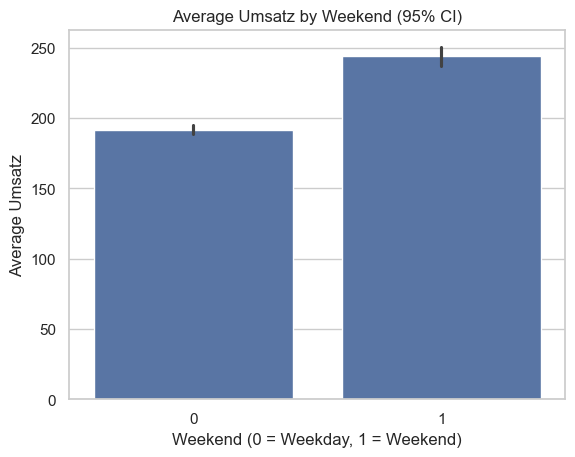

In [64]:
sns.set(style="whitegrid")
sns.barplot(data=train_df, x="is_weekend", y="Umsatz", errorbar=('ci', 95))
plt.title("Average Umsatz by Weekend (95% CI)")
plt.xlabel("Weekend (0 = Weekday, 1 = Weekend)")
plt.ylabel("Average Umsatz")
plt.show()

/var/folders/fs/6ny7ff4d4rx1qjx05w34yt0m0000gn/T/ipykernel_43336/285058313.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_df, x="KielerWoche", y="Umsatz", errorbar=('ci', 95), palette="Blues")


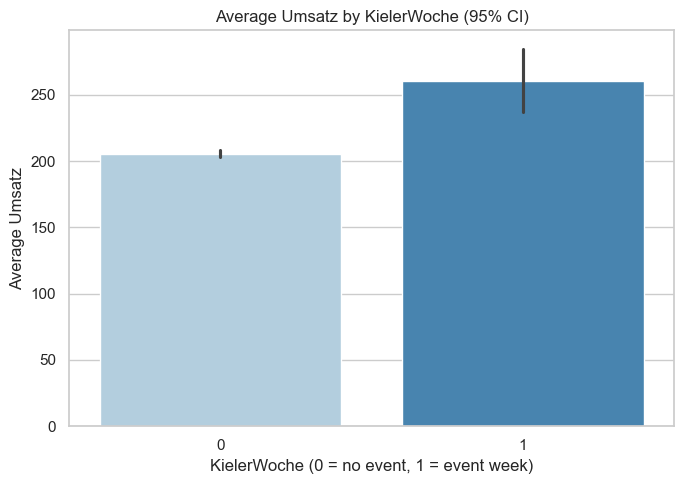

In [65]:
plt.figure(figsize=(7, 5))
sns.barplot(data=train_df, x="KielerWoche", y="Umsatz", errorbar=('ci', 95), palette="Blues")
plt.title("Average Umsatz by KielerWoche (95% CI)")
plt.xlabel("KielerWoche (0 = no event, 1 = event week)")
plt.ylabel("Average Umsatz")
plt.tight_layout()
plt.show()

/var/folders/fs/6ny7ff4d4rx1qjx05w34yt0m0000gn/T/ipykernel_43336/1433026362.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_df, x="is_holiday", y="Umsatz", errorbar=('ci', 95), palette="Greens")


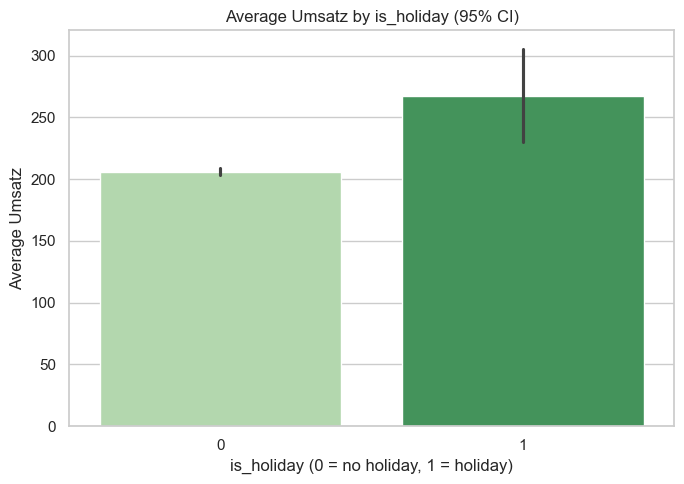

In [66]:
plt.figure(figsize=(7, 5))
sns.barplot(data=train_df, x="is_holiday", y="Umsatz", errorbar=('ci', 95), palette="Greens")
plt.title("Average Umsatz by is_holiday (95% CI)")
plt.xlabel("is_holiday (0 = no holiday, 1 = holiday)")
plt.ylabel("Average Umsatz")
plt.tight_layout()
plt.show()

## Feature Engineering on Train Dataset Part 3

In [67]:
train_df['is_off'] = ((train_df['is_weekend'] == 1) | (train_df['is_holiday'] == 1)).astype(int)

In [68]:
train_df = train_df.drop(columns=['is_weekend', 'is_holiday'])

In [69]:
train_df

,id,Datum,Umsatz,KielerWoche,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos,is_off
0,1307011,2013-07-01,148.828353,0,1,0,0,0,0,0,0.000000,1.00000,-0.5,-0.866025,0
1,1307013,2013-07-01,201.198426,0,0,0,1,0,0,0,0.000000,1.00000,-0.5,-0.866025,0
2,1307015,2013-07-01,317.475875,0,0,0,0,0,1,0,0.000000,1.00000,-0.5,-0.866025,0
3,1307012,2013-07-01,535.856285,0,0,1,0,0,0,0,0.000000,1.00000,-0.5,-0.866025,0
4,1307014,2013-07-01,65.890169,0,0,0,0,1,0,0,0.000000,1.00000,-0.5,-0.866025,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,1807315,2018-07-31,261.341313,0,0,0,0,0,1,0,0.781831,0.62349,-0.5,-0.866025,0
9330,1807311,2018-07-31,123.075682,0,1,0,0,0,0,0,0.781831,0.62349,-0.5,-0.866025,0
9331,1807313,2018-07-31,285.872616,0,0,0,1,0,0,0,0.781831,0.62349,-0.5,-0.866025,0
9332,1807312,2018-07-31,586.081666,0,0,1,0,0,0,0,0.781831,0.62349,-0.5,-0.866025,0


In [70]:
train_df.to_csv('train_df_for_modeling.csv', index=False)

## Feature Engineering on Test Dataset

In [71]:
test_df

,id,Datum,Warengruppe
0,1808011,2018-08-01,1
710,1808013,2018-08-01,3
1065,1808014,2018-08-01,4
1419,1808015,2018-08-01,5
355,1808012,2018-08-01,2
...,...,...,...
354,1907301,2019-07-30,1
709,1907302,2019-07-30,2
1773,1907305,2019-07-30,5
1418,1907304,2019-07-30,4


In [72]:
test_df['Datum'] = pd.to_datetime(test_df['Datum'])
test_df['weekday'] = test_df['Datum'].dt.day_name()

In [73]:
test_df

,id,Datum,Warengruppe,weekday
0,1808011,2018-08-01,1,Wednesday
710,1808013,2018-08-01,3,Wednesday
1065,1808014,2018-08-01,4,Wednesday
1419,1808015,2018-08-01,5,Wednesday
355,1808012,2018-08-01,2,Wednesday
...,...,...,...,...
354,1907301,2019-07-30,1,Tuesday
709,1907302,2019-07-30,2,Tuesday
1773,1907305,2019-07-30,5,Tuesday
1418,1907304,2019-07-30,4,Tuesday


In [74]:
test_df['weekday'] = test_df['Datum'].dt.weekday  

In [75]:
test_df['is_weekend'] = test_df['weekday'].isin([5, 6]).astype(int)

In [76]:
test_df['Datum'] = pd.to_datetime(test_df['Datum'])

In [77]:
test_merged_df = pd.merge(test_df, kiwo_df, on='Datum', how='left')

In [78]:
test_merged_df['KielerWoche'] = test_merged_df['KielerWoche'].fillna(0)

In [79]:
test_merged_df = test_merged_df.sort_values('Datum').reset_index(drop=True)

In [80]:
test_df['weekday'] = test_df['Datum'].dt.weekday
test_df['month'] = test_df['Datum'].dt.month

In [81]:
test_df['weekday_sin'] = np.sin(2 * np.pi * test_df['weekday'] / 7)
test_df['weekday_cos'] = np.cos(2 * np.pi * test_df['weekday'] / 7)

In [82]:
test_df['month_sin'] = np.sin(2 * np.pi * test_df['month'] / 12)
test_df['month_cos'] = np.cos(2 * np.pi * test_df['month'] / 12)

In [83]:
test_df['is_holiday'] = test_df['Datum'].isin(holiday_dates).astype(int)

/var/folders/fs/6ny7ff4d4rx1qjx05w34yt0m0000gn/T/ipykernel_43336/3785794079.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  test_df['is_holiday'] = test_df['Datum'].isin(holiday_dates).astype(int)


In [84]:
test_df['is_off'] = ((test_df['is_weekend'] == 1) | (test_df['is_holiday'] == 1)).astype(int)

In [85]:
test_df

,id,Datum,Warengruppe,weekday,is_weekend,month,weekday_sin,weekday_cos,month_sin,month_cos,is_holiday,is_off
0,1808011,2018-08-01,1,2,0,8,0.974928,-0.222521,-0.866025,-0.500000,0,0
710,1808013,2018-08-01,3,2,0,8,0.974928,-0.222521,-0.866025,-0.500000,0,0
1065,1808014,2018-08-01,4,2,0,8,0.974928,-0.222521,-0.866025,-0.500000,0,0
1419,1808015,2018-08-01,5,2,0,8,0.974928,-0.222521,-0.866025,-0.500000,0,0
355,1808012,2018-08-01,2,2,0,8,0.974928,-0.222521,-0.866025,-0.500000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
354,1907301,2019-07-30,1,1,0,7,0.781831,0.623490,-0.500000,-0.866025,0,0
709,1907302,2019-07-30,2,1,0,7,0.781831,0.623490,-0.500000,-0.866025,0,0
1773,1907305,2019-07-30,5,1,0,7,0.781831,0.623490,-0.500000,-0.866025,0,0
1418,1907304,2019-07-30,4,1,0,7,0.781831,0.623490,-0.500000,-0.866025,0,0


In [86]:
warengruppe_dummies = pd.get_dummies(test_df['Warengruppe'], prefix='Warengruppe', drop_first=False).astype(int)

In [87]:
test_df = pd.concat([test_df.drop(columns=['Warengruppe', 'weekday', 'month']), warengruppe_dummies], axis=1)

In [88]:
test_df = test_df.drop(columns=['is_weekend', 'is_holiday'])

In [89]:
test_df

,id,Datum,weekday_sin,weekday_cos,month_sin,month_cos,is_off,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6
0,1808011,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,1,0,0,0,0,0
710,1808013,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,1,0,0,0
1065,1808014,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,0,1,0,0
1419,1808015,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,0,0,1,0
355,1808012,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,1907301,2019-07-30,0.781831,0.623490,-0.500000,-0.866025,0,1,0,0,0,0,0
709,1907302,2019-07-30,0.781831,0.623490,-0.500000,-0.866025,0,0,1,0,0,0,0
1773,1907305,2019-07-30,0.781831,0.623490,-0.500000,-0.866025,0,0,0,0,0,1,0
1418,1907304,2019-07-30,0.781831,0.623490,-0.500000,-0.866025,0,0,0,0,1,0,0


In [90]:
test_df = pd.merge(test_df, kiwo_df, on='Datum', how='left')

In [91]:
test_df['KielerWoche'] = test_df['KielerWoche'].fillna(0).astype(int)

In [92]:
test_df

,id,Datum,weekday_sin,weekday_cos,month_sin,month_cos,is_off,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,KielerWoche
0,1808011,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,1,0,0,0,0,0,0
1,1808013,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,1,0,0,0,0
2,1808014,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,0,1,0,0,0
3,1808015,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,0,0,1,0,0
4,1808012,2018-08-01,0.974928,-0.222521,-0.866025,-0.500000,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,1907301,2019-07-30,0.781831,0.623490,-0.500000,-0.866025,0,1,0,0,0,0,0,0
1826,1907302,2019-07-30,0.781831,0.623490,-0.500000,-0.866025,0,0,1,0,0,0,0,0
1827,1907305,2019-07-30,0.781831,0.623490,-0.500000,-0.866025,0,0,0,0,0,1,0,0
1828,1907304,2019-07-30,0.781831,0.623490,-0.500000,-0.866025,0,0,0,0,1,0,0,0


In [93]:
test_df.isna().any()

id               False
Datum            False
weekday_sin      False
weekday_cos      False
month_sin        False
month_cos        False
is_off           False
Warengruppe_1    False
Warengruppe_2    False
Warengruppe_3    False
Warengruppe_4    False
Warengruppe_5    False
Warengruppe_6    False
KielerWoche      False
dtype: bool

In [94]:
test_id = test_df['id']

In [95]:
test_id

0       1808011
1       1808013
2       1808014
3       1808015
4       1808012
         ...   
1825    1907301
1826    1907302
1827    1907305
1828    1907304
1829    1907303
Name: id, Length: 1830, dtype: int64

In [96]:
test_df = test_df.drop(columns=['id','Datum'])

In [97]:
test_df

,weekday_sin,weekday_cos,month_sin,month_cos,is_off,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,KielerWoche
0,0.974928,-0.222521,-0.866025,-0.500000,0,1,0,0,0,0,0,0
1,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,1,0,0,0,0
2,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,0,1,0,0,0
3,0.974928,-0.222521,-0.866025,-0.500000,0,0,0,0,0,1,0,0
4,0.974928,-0.222521,-0.866025,-0.500000,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1825,0.781831,0.623490,-0.500000,-0.866025,0,1,0,0,0,0,0,0
1826,0.781831,0.623490,-0.500000,-0.866025,0,0,1,0,0,0,0,0
1827,0.781831,0.623490,-0.500000,-0.866025,0,0,0,0,0,1,0,0
1828,0.781831,0.623490,-0.500000,-0.866025,0,0,0,0,1,0,0,0


In [98]:
desired_order = ['KielerWoche', 'Warengruppe_1', 'Warengruppe_2', 'Warengruppe_3',
       'Warengruppe_4', 'Warengruppe_5', 'Warengruppe_6', 'weekday_sin',
       'weekday_cos', 'month_sin', 'month_cos', 'is_off']

test_df = test_df.reindex(columns=desired_order, fill_value=0)

In [99]:
test_df

,KielerWoche,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,weekday_sin,weekday_cos,month_sin,month_cos,is_off
0,0,1,0,0,0,0,0,0.974928,-0.222521,-0.866025,-0.500000,0
1,0,0,0,1,0,0,0,0.974928,-0.222521,-0.866025,-0.500000,0
2,0,0,0,0,1,0,0,0.974928,-0.222521,-0.866025,-0.500000,0
3,0,0,0,0,0,1,0,0.974928,-0.222521,-0.866025,-0.500000,0
4,0,0,1,0,0,0,0,0.974928,-0.222521,-0.866025,-0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1825,0,1,0,0,0,0,0,0.781831,0.623490,-0.500000,-0.866025,0
1826,0,0,1,0,0,0,0,0.781831,0.623490,-0.500000,-0.866025,0
1827,0,0,0,0,0,1,0,0.781831,0.623490,-0.500000,-0.866025,0
1828,0,0,0,0,1,0,0,0.781831,0.623490,-0.500000,-0.866025,0


In [100]:
test_df.to_csv('test_df_for_modeling.csv', index=False)
test_id.to_csv('test_id_for_modeling.csv', index=False)